## Testing Notebook


In [ ]:
%load_ext autoreload
%autoreload 2

from pprint import pprint
import os 
import matplotlib.pyplot as plt
import numpy as np
import logging
import skimage
from fibsem import acquire, utils
from fibsem.structures import BeamType

from autoscript_sdb_microscope_client.structures import (
        AdornedImage,
        BitmapPatternDefinition,
        GrabFrameSettings,
        ManipulatorPosition,
        MoveSettings,
        StagePosition,
    )

microscope, settings = utils.setup_session()

In [ ]:
from autoscript_sdb_microscope_client.structures import (
        AdornedImage,
        BitmapPatternDefinition,
        GrabFrameSettings,
        ManipulatorPosition,
        MoveSettings,
        StagePosition,
    )

In [ ]:
from fibsem import utils
from fibsem.microscope import FibsemMicroscope

microscope, settings = utils.setup_session()


In [ ]:
microscope.connection.imaging.set_active_view(4)

scope=microscope.connection

In [ ]:
scope.detector.camera_settings.color='Red'
scope.detector.camera_settings.exposure_time=100e-03


In [ ]:
scope.detector.insert()

aproximate_focus=0.007730487467
range=50e-06
stepsize=10e-06


scope.detector.camera_settings.focus.value



In [ ]:
intensity=0.01
exposure=0.003
available_modes=['Fluorescence', 'Reflection']
available_colors=['Blue', 'GreenYellow', 'Red', 'Violet']
FLM_mode='Reflection'
color='GreenYellow'
scope.detector.brightness.value=intensity
settings=GrabFrameSettings(exposure_time=exposure,emission_type=color)
scope.detector.camera_settings.filter.type.value=FLM_mode
#scope.detector.camera_settings.emission.type.value=color



scope.imaging.grab_frame(settings)

In [112]:
from datetime import datetime




def _sharpness(img, **kwargs) -> float:
    """Calculate sharpness (accutance) of an image.
    (Acutance: https://en.wikipedia.org/wiki/Acutance)

    Args:
        img (FibsemImage): _description_
        disk_size (int, optional): _description_. Defaults to 5.

    Returns:
        _type_: _description_
    """
    from skimage.filters.rank import gradient
    from skimage.morphology import disk
    disk_size = kwargs.get("disk_size", 5)
    logging.info(f"calculating sharpness (accutance) of image {img}: {disk_size}")
    return np.mean(gradient(skimage.filters.median(np.copy(img.data)), disk(disk_size)))


from dataclasses import dataclass

@dataclass
class ChannelSettings:
    power: float
    exposure_time: float
    color: str
    excitation: str
    emission: str
    mode: str 


def acquire_image(frame_setings: GrabFrameSettings) -> AdornedImage:

    img = scope.imaging.grab_frame(frame_setings)

    return img

from typing import List

def get_zrange(initial_focus: float, rng: float, step: float) -> List[float]:
    start=initial_focus-rng/2
    stop=initial_focus+rng/2
    focus_points=np.arange(start,stop,step)
    return focus_points

def autofocus(initial_focus: float, rng: float, step: float, settings: ChannelSettings):
    
    # set initial focus position
    scope.detector.camera_settings.focus.value=aproximate_focus
    
    # set detector mode
    scope.detector.camera_settings.filter.type.value=settings.mode


    scores=[]
    scope.detector.brightness.value=settings.power
    focus_points = get_zrange(initial_focus, rng, step)

    print(focus_points)

    frame_settings = GrabFrameSettings(
        exposure_time=settings.exposure_time,
        emission_type=settings.color,
    )

    for focus in focus_points:
        # set focus position
        scope.detector.camera_settings.focus.value=focus
        
        # acquire image
        img = acquire_image(frame_setings=frame_settings)
        
        # calculate sharpness of image
        score=_sharpness(img)
        scores.append(score)

    # get 
    idx = np.argmax(scores)
    det_focus = focus_points[idx]

    scope.detector.camera_settings.focus.value=det_focus
    return det_focus



def collect_stack(center,rng,step,channel_settings=[]):

    v: ChannelSettings
    images = []
    
    for k, v in channel_settings.items():
        print(v)
        scope.detector.camera_settings.filter.type.value=v.mode
        scope.detector.brightness.value=v.power
        frame_settings=GrabFrameSettings(exposure_time=v.exposure_time, emission_type=v.color)
        focus_points = get_zrange(center, rng, step)
        counter=0

        zstack = []
        for focus in focus_points:
            
            scope.detector.camera_settings.focus.value=focus
            img = acquire_image(frame_settings)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            img.save(output_directory+timestamp+'_'+k+'_'+str(counter)+'.tif')
            counter+=1
            zstack.append(img.data)
        images.append(zstack)

    return np.asarray(images)


scope.imaging.set_active_view(3)
scope.detector.insert()

aproximate_focus=0.007730487467

output_directory='D:/SvenKlumpe/'

os.makedirs(output_directory, exist_ok=True)

rng=30e-06
stepsize=5e-06
settings = ChannelSettings(
    power=intensity,
    exposure_time=3e-03,
    emission='GreenYellow',
    excitation=None,
    color='GreenYellow',
    mode="Reflection",
)

focus=autofocus(initial_focus=aproximate_focus, 
                rng=rng, 
                step=stepsize, 
                settings=settings)

print(f"best focus: {focus}")

channel_settings = {
    "Reflection": ChannelSettings(
        power=0.01,
        exposure_time=3e-3,
        color="GreenYellow",
        emission="GreenYellow",
        excitation=None,
        mode="Reflection"
    ),
    "GreenYellow": ChannelSettings(
        power=0.60,
        exposure_time=1500e-3,
        color="GreenYellow",
        emission="GreenYellow",
        excitation=None,
        mode="Fluorescence"
    )
}

rng=15e-06
stepsize=1e-06

focus=scope.detector.camera_settings.focus.value
images = collect_stack(focus, rng, stepsize, channel_settings)

# restore initial focus
scope.detector.camera_settings.focus.value =  focus

[0.00771549 0.00772049 0.00772549 0.00773049 0.00773549 0.00774049
 0.00774549]
2025-03-20 18:40:57,910 — root — INFO — _sharpness:20 — calculating sharpness (accutance) of image AdornedImage(width=1128, height=1128, bit_depth=16): 5


c:\Users\User\miniconda3\envs\openfibsem\lib\site-packages\skimage\filters\rank\generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (4040), equivalent to an approximate bitdepth of 12.0.
  image, footprint, out, mask, n_bins = _preprocess_input(


2025-03-20 18:41:02,231 — root — INFO — _sharpness:20 — calculating sharpness (accutance) of image AdornedImage(width=1128, height=1128, bit_depth=16): 5


c:\Users\User\miniconda3\envs\openfibsem\lib\site-packages\skimage\filters\rank\generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (4096), equivalent to an approximate bitdepth of 12.0.
  image, footprint, out, mask, n_bins = _preprocess_input(


2025-03-20 18:41:06,536 — root — INFO — _sharpness:20 — calculating sharpness (accutance) of image AdornedImage(width=1128, height=1128, bit_depth=16): 5
2025-03-20 18:41:10,885 — root — INFO — _sharpness:20 — calculating sharpness (accutance) of image AdornedImage(width=1128, height=1128, bit_depth=16): 5


c:\Users\User\miniconda3\envs\openfibsem\lib\site-packages\skimage\filters\rank\generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (3645), equivalent to an approximate bitdepth of 11.8.
  image, footprint, out, mask, n_bins = _preprocess_input(


2025-03-20 18:41:14,828 — root — INFO — _sharpness:20 — calculating sharpness (accutance) of image AdornedImage(width=1128, height=1128, bit_depth=16): 5


c:\Users\User\miniconda3\envs\openfibsem\lib\site-packages\skimage\filters\rank\generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (3585), equivalent to an approximate bitdepth of 11.8.
  image, footprint, out, mask, n_bins = _preprocess_input(


2025-03-20 18:41:18,816 — root — INFO — _sharpness:20 — calculating sharpness (accutance) of image AdornedImage(width=1128, height=1128, bit_depth=16): 5


c:\Users\User\miniconda3\envs\openfibsem\lib\site-packages\skimage\filters\rank\generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (3264), equivalent to an approximate bitdepth of 11.7.
  image, footprint, out, mask, n_bins = _preprocess_input(


2025-03-20 18:41:22,425 — root — INFO — _sharpness:20 — calculating sharpness (accutance) of image AdornedImage(width=1128, height=1128, bit_depth=16): 5


c:\Users\User\miniconda3\envs\openfibsem\lib\site-packages\skimage\filters\rank\generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (2935), equivalent to an approximate bitdepth of 11.5.
  image, footprint, out, mask, n_bins = _preprocess_input(


best focus: 0.0077154874669999995
ChannelSettings(power=0.01, exposure_time=0.003, color='GreenYellow', excitation=None, emission='GreenYellow', mode='Reflection')
ChannelSettings(power=0.6, exposure_time=1.5, color='GreenYellow', excitation=None, emission='GreenYellow', mode='Fluorescence')


(15, 1128, 1128)
(15, 1128, 1128)


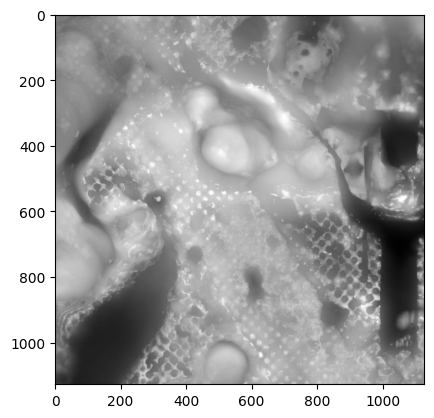

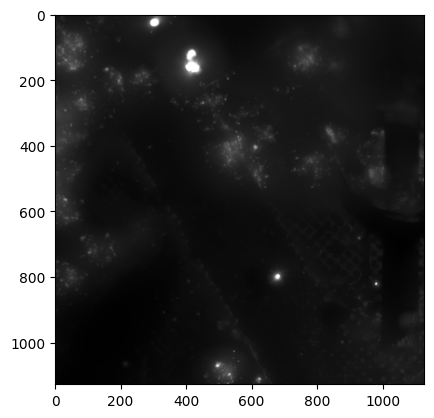

In [113]:
ch0= images[0]
ch1= images[1]

print(ch0.shape)
print(ch1.shape)
plt.imshow(np.max(ch0, axis=0), cmap="gray")
plt.show()

plt.imshow(np.max(ch1, axis=0), cmap="gray")
plt.show()

In [110]:
# flip grid
# insert objective
# for each position
#   move to position
#   auto-focus
#   acquire z-stack
#   save image
# retract objective


# scope.detector.insert()

scope.detector.retract()

In [ ]:
# scope.specimen.stage.move_absolute

In [ ]:
import os, glob
PATH = r"D:\SvenKlumpe"

filenames = glob.glob(os.path.join(PATH, "*.tif"))
import matplotlib.pyplot as plt

print(filenames)

for fname in filenames:
    image = AdornedImage.load(fname)
    print(image.metadata.binary_result)
    # for attr in getattr
    plt.imshow(image.data, cmap="gray")
    plt.show()
    # break

In [ ]:
fov = image.metadata.optics.full_scan_field_of_view
wfov, vfov = fov.width, fov.height

height, width = image.data.shape
pixel_size = wfov/width
print(wfov, vfov)
print(f"Pixel size: {pixel_size}")


In [ ]:
scope.detector.insert()
aproximate_focus=0.007730487467
scope.detector.camera_settings.focus.value=aproximate_focus


scope.imaging.grab_frame()
scope.detector.retract()




In [ ]:
img=scope.imaging.grab_frame()

In [ ]:
from pprint import pprint
print(img.metadata.metadata_as_xml)

In [ ]:
img.metadata.optics.full